# DTSA 5510 Final Project

## Project Overview

The Starbucks Udacity Data Scientist Nanodegree Capstone challenge data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Periodically, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). However, some users might not receive any offer during certain weeks. The challenge has now ended so there is not an active site for the the challenge itself, but I was able to obtain the data from github. 

The goal for my project is to predict whether a customer/offer from the dataset will be completed or not.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
import itertools
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor



pd.options.mode.chained_assignment = None  # default='warn'



**Import Data**

The data comes from 3 files:

portfolio.json - offer ids and meta data about each offer (duration, type, etc.) 

profile.json - demographic data for each customer

transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [2]:
# read json files into dataframes
portfolio = pd.read_json(r'/Users/emilyhill/Documents/DTSA Unsupervised/starbuck_capstone-master/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json(r'/Users/emilyhill/Documents/DTSA Unsupervised/starbuck_capstone-master/data/profile.json', orient='records', lines=True)
transcript = pd.read_json(r'/Users/emilyhill/Documents/DTSA Unsupervised/starbuck_capstone-master/data/transcript.json', orient='records', lines=True)

# EDA

I will preform exploratory data analysis to understand what is included in each dataset and determine what to use for my model.

**Portfolio Data**

In [3]:
portfolio #Information about each of the 10 offers

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


id (string) - offer id <br>
offer_type (string) - type of offer ie BOGO, discount, informational <br>
difficulty (int) - minimum required spend to complete an offer <br>
reward (int) - reward given for completing an offer <br>
duration (int) - <br>
channels (list of strings) <br>

In [27]:
print('Breakdown of offer Channels')
channels = ['web', 'email', 'mobile', 'social']
portfolio_df.groupby('offer_type').sum()[channels].sum()

Breakdown of offer Channels


web        8
email     10
mobile     9
social     6
dtype: int64

Text(0, 0.5, 'Number of Offers')

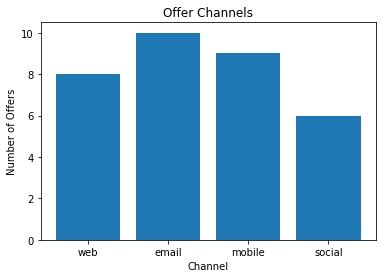

In [28]:
plt.bar(channels,portfolio_df.groupby('offer_type').sum()[channels].sum().tolist())
plt.title('Offer Channels')
plt.xlabel('Channel')
plt.ylabel('Number of Offers')

**Profile Data**

In [7]:
profile #dataframe with 1 row for each customer with demographics - 17000 customers 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


age (int) - age of the customer <br>
became_member_on (int) - date when customer created an app account <br>
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F) <br>
id (str) - customer id <br>
income (float) - customer's income

**What is the mean amount of time that a user has been a member?**

Average Member Length:  2257 days 10:47:49.835294144


Text(0.5, 1.0, 'Profile Length Hist')

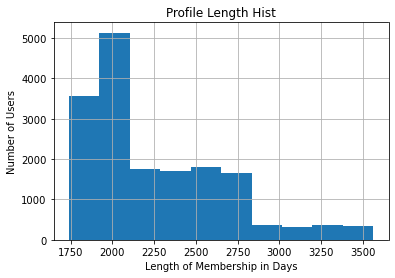

In [8]:
mem_length =pd.to_datetime('today').normalize()-pd.to_datetime(profile.became_member_on, format='%Y%m%d')
print('Average Member Length: ', mem_length.mean())#.astype('timedelta64[D]')
days = mem_length.dt.days
plt.hist(days.tolist())
plt.xlabel('Length of Membership in Days')
plt.ylabel('Number of Users')
plt.grid()
plt.title('Profile Length Hist')

**What is the income spread of all users?**

Text(0.5, 1.0, 'User Income Hist')

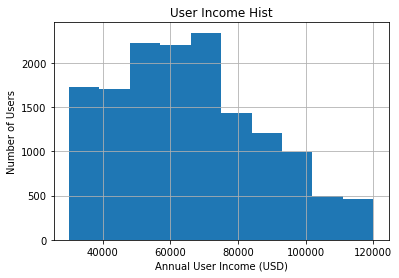

In [9]:
profile.income.hist()
plt.xlabel('Annual User Income (USD)')
plt.ylabel('Number of Users')
plt.title('User Income Hist')

**How many profiles are over 100 years old?** We should probably get rid of data associated with those accounts in data cleaning

In [10]:
profile[profile.age > 100].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


**What is the breakdown of Genders on user profiles?**

Text(0, 0.5, 'Number of Users')

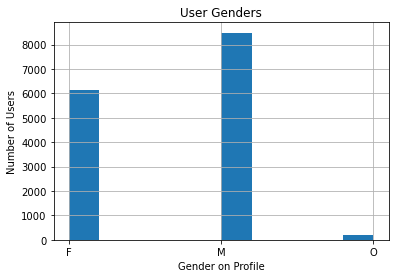

In [11]:
profile.gender.hist()
plt.title('User Genders')
plt.xlabel('Gender on Profile')
plt.ylabel('Number of Users')

**Transcript Data**

In [12]:
transcript #time series records of transactions and offers (recieved, viewed & completed)
#306534 total records

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


Columns in transcript:

event (str) - record description (ie transaction, offer received, offer viewed, etc.) <br>
person (str) - customer id <br>
time (int) - time in hours. The data begins at time t=0 <br>
value - (dict of strings) - either an offer id or transaction amount depending on the record

**How many customers are included in the transcript data with 306,534 total transactions?**

In [13]:
print('Total Unique Customers in Data: ', len(transcript.person.unique()))
print('On average that is ', len(transcript)/len(transcript.person.unique()), 'events per customer')

Total Unique Customers in Data:  17000
On average that is  18.031411764705883 events per customer


**What is the makeup of types of records/events in the data? (i.e. offer received, offer, completed, offer viewed, transaction)**

Text(0.5, 1.0, 'Transcript Data Makeup')

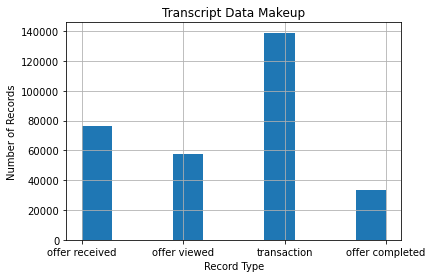

In [14]:
transcript.event.hist()
plt.xlabel('Record Type')
plt.ylabel('Number of Records')
plt.title('Transcript Data Makeup')

The data has about double the amount of transaction records than any other type- which is to be expected, it would not make sense to have as many transactions as offers. In terms of offers, the most common type of record is recieved offers, then a smaller number of records are viewed by users and even less are completed. 

# Data Cleaning 

In the data cleaning step I will be changing the formatting of the data to work with machine learning models. 

**Clean Portfolio Data** <br>
First I am creating columns for each channel ('web', 'email', 'mobile', 'social') which have a 0 or 1 for whether or not that channel is used. Then I also add a column ('name') to better describe the unique offers. The format of the name column is offerType_reward_difficulty_duration. I also change normalize the reward and difficulty columns and change offer_type to an int.

In [15]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['difficulty','reward']
portfolio[numerical] = scaler.fit_transform(portfolio[numerical])

In [16]:
# replacing the 'offer_type' by integers representing each offer type
labels_offer_type = portfolio['offer_type'].astype('category').cat.categories.tolist()
replace_map_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(replace_map_offer_type)
portfolio.replace(replace_map_offer_type, inplace=True)
portfolio['oid'] = portfolio['id']
labels_offer_id = portfolio['id'].astype('category').cat.categories.tolist()
replace_map_offer_id = {'id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(replace_map_offer_id)
portfolio.replace(replace_map_offer_id, inplace=True)

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}
{'id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}


In [17]:
#one hot encoded channels columns
for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1

#drop channels column
portfolio_df = portfolio.drop('channels', axis=1) #portfolio_df is cleaned version of portfolio
portfolio_df['name'] = portfolio_df.offer_type.astype(str) + "_" + portfolio_df.difficulty.astype(str) +\
                      "_" + portfolio_df.reward.astype(str) + \
                     "_" + portfolio_df.duration.astype(str)

portfolio_df.rename(columns={'id':'offer_id'},inplace=True)

portfolio_df

,reward,difficulty,duration,offer_type,offer_id,oid,web,email,mobile,social,name
0,1.0,0.50,7,1,8,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1_0.5_1.0_7
1,1.0,0.50,5,1,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1_0.5_1.0_5
2,0.0,0.00,4,3,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,3_0.0_0.0_4
3,0.5,0.25,7,1,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1_0.25_0.5_7
4,0.5,1.00,10,2,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,2_1.0_0.5_10
5,0.3,0.35,7,2,2,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,2_0.35000000000000003_0.30000000000000004_7
6,0.2,0.50,10,2,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,2_0.5_0.2_10
7,0.0,0.00,3,3,6,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,3_0.0_0.0_3
8,0.5,0.25,5,1,9,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1_0.25_0.5_5
9,0.2,0.50,7,2,3,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,2_0.5_0.2_7


In [18]:
portfolio_df.isnull().sum()

reward        0
difficulty    0
duration      0
offer_type    0
offer_id      0
oid           0
web           0
email         0
mobile        0
social        0
name          0
dtype: int64

In [19]:
portfolioC = portfolio_df[['offer_id', 'reward', 'difficulty', 'duration', 'offer_type', 'web', 'email', 'mobile', 'social']]
portfolioC

,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social
0,8,1.0,0.50,7,1,0,1,1,1
1,5,1.0,0.50,5,1,1,1,1,1
2,4,0.0,0.00,4,3,1,1,1,0
3,7,0.5,0.25,7,1,1,1,1,0
4,1,0.5,1.00,10,2,1,1,0,0
5,2,0.3,0.35,7,2,1,1,1,1
6,10,0.2,0.50,10,2,1,1,1,1
7,6,0.0,0.00,3,3,0,1,1,1
8,9,0.5,0.25,5,1,1,1,1,1
9,3,0.2,0.50,7,2,1,1,1,0


**Clean Profile Data**<br>
For the profile data, I will remove the accounts that are over 100 years old and missing amplyfiying data like age and income- these are not going to be helpful. Also, I convert the 'became_member_on' column to a date. The income and age columns get turned into ranges or groups. 

In [20]:
profile_df = profile[profile.age < 100]
profile_df

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [21]:
labels_customer_id = transcript['person'].astype('category').cat.categories.tolist()
replace_map_customer_id = {'id' : {k: v for k,v in zip(labels_customer_id,list(range(1,len(labels_customer_id)+1)))}}
profile_df.replace(replace_map_customer_id, inplace=True)

In [22]:
#Add age group column
profile_df['age_group'] = pd.cut(profile_df['age'], bins=[17, 22, 35, 60, 103],labels=[1, 2, 3, 4])
#Add income range column
profile_df['income_range'] = pd.cut(profile_df['income'], bins=[29999, 60000, 90000, 120001],labels=[1, 2, 3])
#Replace gender categories
labels_gender = profile_df['gender'].astype('category').cat.categories.tolist()
replace_map_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
profile_df.replace(replace_map_gender, inplace=True)
print(replace_map_gender)

{'gender': {'F': 1, 'M': 2, 'O': 3}}


In [23]:
#convert to string
profile_df['became_member_on'] = profile_df.became_member_on.apply(lambda x: str(x))
#convert to datetime format
profile_df['became_member_on'] = pd.to_datetime(profile_df.became_member_on).dt.date


In [24]:
#Date data was released
date_time_str = '11/01/19'
date_time_obj = datetime.datetime.strptime(date_time_str, '%d/%m/%y').date()
profile_df['membership_days'] = date_time_obj - profile_df['became_member_on']
# removing the 'days' unit
profile_df['membership_days'] = profile_df['membership_days'].dt.days
#add mem type
profile_df['member_type'] = pd.cut(profile_df['membership_days'], bins=[0, 250, 1000, 2000],labels=[1, 2, 3])

profile_df

,gender,age,id,became_member_on,income,age_group,income_range,membership_days,member_type
1,1,55,399,2017-07-15,112000.0,3,3,545,2
3,1,75,7997,2017-05-09,100000.0,4,3,612,2
5,2,68,15044,2018-04-26,70000.0,4,2,260,2
8,2,65,3729,2018-02-09,53000.0,4,1,336,2
12,2,58,3060,2017-11-11,51000.0,3,1,426,2
...,...,...,...,...,...,...,...,...,...
16995,1,45,7265,2018-06-04,54000.0,3,1,221,1
16996,2,61,2888,2018-07-13,72000.0,4,2,182,1
16997,2,49,106,2017-01-26,73000.0,3,2,715,2
16998,1,83,10568,2016-03-07,50000.0,4,1,1040,3


In [25]:
profile_df.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
age_group           0
income_range        0
membership_days     0
member_type         0
dtype: int64

In [26]:
profileC = profile_df[['id', 'gender', 'age_group', 'income_range', 'member_type']]
profileC

,id,gender,age_group,income_range,member_type
1,399,1,3,3,2
3,7997,1,4,3,2
5,15044,2,4,2,2
8,3729,2,4,1,2
12,3060,2,3,1,2
...,...,...,...,...,...
16995,7265,1,3,1,1
16996,2888,2,4,2,1
16997,106,2,3,2,2
16998,10568,1,4,1,3


**Clean Transcript Data** <br>
For the transcript dataset, which is a list of records of transactions and offers over time. I change the value column to map to an amount or offer_id column based on the event type. I also replace the person column with id.

In [30]:
""" Encode offer_id and amount in value column """

def encode_offer_id(x):
    try :
        return x['offer id']
    except:
        return x['offer_id']
def encode_offer_val(x):
    try :
        oid = x['offer id']
    except:
        oid = x['offer_id']
    return portfolio[portfolio['oid']==oid]['reward'].iloc[0]
transcript_encoded = transcript.copy()
transcript_encoded['offer_id'] = '' # datatype : string
transcript_encoded['amount'] = 0  # datatype : integer
transcript_encoded['offer_value'] = 0  # datatype : integer    
transcript_encoded['offer_id'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])].value.apply(encode_offer_id)
transcript_encoded['offer_value'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])].value.apply(encode_offer_val)
transcript_encoded['amount'] =  transcript[transcript.event.isin(['transaction'])].value.apply(lambda x: x['amount'])

transcript_df = transcript_encoded

In [31]:
labels_event = transcript_df['event'].astype('category').cat.categories.tolist()
replace_map_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
transcript_df.replace(replace_map_event, inplace=True)

In [32]:
transcript_df.rename(columns={'person':'id'},inplace=True)
transcript_df.replace(replace_map_customer_id, inplace=True)

In [33]:
transcript_df.replace(replace_map_offer_id['id'], inplace=True)
transcript_df

,id,event,value,time,offer_id,amount,offer_value
0,7997,2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,7.0,NaN,0.5
1,10736,2,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1.0,NaN,0.5
2,15044,2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,3.0,NaN,0.2
3,9525,2,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,10.0,NaN,0.2
4,6940,2,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,5.0,NaN,1.0
...,...,...,...,...,...,...,...
306529,12028,4,{'amount': 1.5899999999999999},714,NaN,1.59,NaN
306530,6914,4,{'amount': 9.53},714,NaN,9.53,NaN
306531,10723,4,{'amount': 3.61},714,NaN,3.61,NaN
306532,7882,4,{'amount': 3.5300000000000002},714,NaN,3.53,NaN


In [35]:
transcript_df['offer_id'] = transcript_df['offer_id'].apply(lambda x: 0 if np.isnan(x) else x)
transcript_df['offer_value'] = transcript_df['offer_value'].apply(lambda x: 0 if np.isnan(x) else x)
transcript_df['amount'] = transcript_df['amount'].apply(lambda x: 0 if np.isnan(x) else x)

In [36]:
transcript_df.isnull().sum()

id             0
event          0
value          0
time           0
offer_id       0
amount         0
offer_value    0
dtype: int64

In [37]:
transcript_df['offer_id'] = transcript_df['offer_id'].astype(int)#.info()

In [38]:
transcriptC = transcript_df[['id', 'time', 'event', 'offer_id', 'offer_value', 'amount']]
portfolioC

,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social
0,8,1.0,0.50,7,1,0,1,1,1
1,5,1.0,0.50,5,1,1,1,1,1
2,4,0.0,0.00,4,3,1,1,1,0
3,7,0.5,0.25,7,1,1,1,1,0
4,1,0.5,1.00,10,2,1,1,0,0
5,2,0.3,0.35,7,2,1,1,1,1
6,10,0.2,0.50,10,2,1,1,1,1
7,6,0.0,0.00,3,3,0,1,1,1
8,9,0.5,0.25,5,1,1,1,1,1
9,3,0.2,0.50,7,2,1,1,1,0


## Join Dataframes

Next I will be merging the three dataframes together so that I have one master dataset.

In [39]:
master_df = transcriptC.merge(portfolioC,how='left',on='offer_id')
master_df = master_df.merge(profileC,how ='left', on = 'id')

In [40]:
#change offer_type nans to 0
master_df['offer_type'] = master_df['offer_type'].fillna(0)
master_df['reward'] = master_df['reward'].fillna(0)
master_df['amount'] = master_df['amount'].fillna(0)
master_df['difficulty'] = master_df['difficulty'].fillna(0)
master_df['duration'] = master_df['duration'].fillna(0)
master_df = master_df[master_df['event']<3].reset_index(drop=True).dropna()
master_df

,id,time,event,offer_id,offer_value,amount,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age_group,income_range,member_type
0,7997,0,2,7,0.5,0.0,0.5,0.25,7.0,1.0,1.0,1.0,1.0,0.0,1.0,4,3,2
2,15044,0,2,3,0.2,0.0,0.2,0.50,7.0,2.0,1.0,1.0,1.0,0.0,2.0,4,2,2
5,3729,0,2,9,0.5,0.0,0.5,0.25,5.0,1.0,1.0,1.0,1.0,1.0,2.0,4,1,2
7,3060,0,2,4,0.0,0.0,0.0,0.00,4.0,3.0,1.0,1.0,1.0,0.0,2.0,3,1,2
8,11411,0,2,1,0.5,0.0,0.5,1.00,10.0,2.0,1.0,1.0,0.0,0.0,1.0,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109849,16203,714,1,1,0.5,0.0,0.5,1.00,10.0,2.0,1.0,1.0,0.0,0.0,1.0,2,1,2
109850,4608,714,1,10,0.2,0.0,0.2,0.50,10.0,2.0,1.0,1.0,1.0,1.0,2.0,3,2,1
109851,787,714,1,2,0.3,0.0,0.3,0.35,7.0,2.0,1.0,1.0,1.0,1.0,2.0,3,2,2
109854,8783,714,1,10,0.2,0.0,0.2,0.50,10.0,2.0,1.0,1.0,1.0,1.0,2.0,3,1,1


In [41]:
master_df.isnull().sum()

id              0
time            0
event           0
offer_id        0
offer_value     0
amount          0
reward          0
difficulty      0
duration        0
offer_type      0
web             0
email           0
mobile          0
social          0
gender          0
age_group       0
income_range    0
member_type     0
dtype: int64

## Test Train Data Split

First I am going to split the data into features and target labels, then I'll split into train and test data (80/20).<br>
<br>
Those features are as follows: 11 Features<br>
time<br>
offer_id <br>
amount<br>
reward<br>
difficulty<br>
duration<br>
offer_type<br>
gender<br>
age_group<br>
income_range<br>
member_type<br>
<br>
The target to be predicted is: 'event'<br>
1 : offer completed<br>
2 : offer viewed<br>

Note: <br>
Mapping of Numerical values for ‘age_group’ feature:<br>
    1- teenager<br>
    2- young-adult<br>
    3- adult<br>
    4- elderly<br>
Mapping of Numerical values for ‘income_range’ feature:<br>
    1-average (30,000 - 60,000)<br>
    2-above-average (60,0001 - 90,000)<br>
    3-high (more than 90,000)<br>
Mapping of Numerical values for ‘gender’ feature:<br>
    1- F (Female)<br>
    2- M (Male)<br>
    3- O<br>
Mapping of Numerical values for 'offer_type' feature:<br>
    1- bogo<br>
    2- discount<br>
    3- informational<br>
Mapping of Numerical values for ‘event’ feature:<br>
    1- offer completed<br>
    2- offer viewed<br>

In [93]:
# removing any rows that contain NaNs
mid_df = master_df[['time','offer_id','amount','reward','difficulty','duration','offer_type','gender','age_group','income_range', 'member_type', 'event']]
mid_df = mid_df.dropna(how='any',axis=0)
X = mid_df[['time','offer_id','amount','reward','difficulty','duration','offer_type','gender','age_group','income_range', 'member_type']]
Y = mid_df['event']
# normalizing values
scaler = MinMaxScaler()
features = ['time', 'amount', 'reward', 'duration']
X[features] = scaler.fit_transform(X[features])
X

,time,offer_id,amount,reward,difficulty,duration,offer_type,gender,age_group,income_range,member_type
0,0.0,7,0.0,0.5,0.25,0.571429,1.0,1.0,4,3,2
2,0.0,3,0.0,0.2,0.50,0.571429,2.0,2.0,4,2,2
5,0.0,9,0.0,0.5,0.25,0.285714,1.0,2.0,4,1,2
7,0.0,4,0.0,0.0,0.00,0.142857,3.0,2.0,3,1,2
8,0.0,1,0.0,0.5,1.00,1.000000,2.0,1.0,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...
109849,1.0,1,0.0,0.5,1.00,1.000000,2.0,1.0,2,1,2
109850,1.0,10,0.0,0.2,0.50,1.000000,2.0,2.0,3,2,1
109851,1.0,2,0.0,0.3,0.35,0.571429,2.0,2.0,3,2,2
109854,1.0,10,0.0,0.2,0.50,1.000000,2.0,2.0,3,1,1


In [62]:
#Split train data into 80/20 train/test data
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)
X_train

,time,offer_id,amount,reward,difficulty,duration,offer_type,gender,age_group,income_range,member_type
66944,0.596639,2,0.0,0.3,0.35,0.571429,2.0,2.0,3,2,3
73583,0.705882,4,0.0,0.0,0.00,0.142857,3.0,1.0,3,2,2
79106,0.705882,8,0.0,1.0,0.50,0.571429,1.0,1.0,3,2,3
50630,0.521008,5,0.0,1.0,0.50,0.285714,1.0,2.0,3,1,2
23379,0.235294,5,0.0,1.0,0.50,0.285714,1.0,2.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...
96452,0.806723,10,0.0,0.2,0.50,1.000000,2.0,2.0,3,2,1
61102,0.571429,2,0.0,0.3,0.35,0.571429,2.0,2.0,4,1,3
37306,0.470588,8,0.0,1.0,0.50,0.571429,1.0,2.0,3,1,2
3793,0.000000,8,0.0,1.0,0.50,0.571429,1.0,2.0,2,2,3


In [63]:
X_train.isnull().sum()

time            0
offer_id        0
amount          0
reward          0
difficulty      0
duration        0
offer_type      0
gender          0
age_group       0
income_range    0
member_type     0
dtype: int64

# Models
I will use accuracy to score all models tested.

## Unsupervised Model

 I will be trying both agglomerative clustering and kmeans algorithms to try and best model the data. I am using these two clustering algorithms because I expect they may be able to find clusters within the data that relate to whether a customer will follow through with an offer or not.

### Heirarchical Clustering

In [94]:
model = AgglomerativeClustering(n_clusters=2)
# Fit the model KMeans
model.fit(X_test)
pred_event = model.labels_

In [96]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    labels = list(set(ytdf))
    acc = 0
    for perm in list(itertools.permutations(np.arange(0,2))):
        temp_labels = ytdf.replace(labels, perm).tolist()
        acc_list = temp_labels == yp
        if np.mean(acc_list) > acc:
            acc = np.mean(acc_list)
            best_perm = perm
    return best_perm, acc

### Hyperparameter Optimization

In [78]:
links = ['ward', 'complete', 'average', 'single']
dist_mets = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']
best_acc = (0, None) #variable to store best match of parameters
labels = list(set(y_test))
#loop through distance metrics and linkage methods
for link in links:
    for dist_met in dist_mets:
        print('Link:', link, '         Distance metric:', dist_met)
        try:
            model=AgglomerativeClustering(n_clusters = 2, affinity = dist_met, linkage = link)
            model.fit(X_test)#, metric = dist_met, linkage = link)
            labelorder, acc = label_permute_compare(y_test, model.labels_)
            print('Accuracy: ', acc)
            # display confusion matrix here 
            pred_labels = pd.DataFrame(model.labels_).replace(labelorder, labels)
            true_labels = y_test
            conf_matrix = confusion_matrix(true_labels, pred_labels, labels)
            """
            fig, ax = plt.subplots(figsize=(7.5, 7.5))
            ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
            for i in range(conf_matrix.shape[0]):
                for j in range(conf_matrix.shape[1]):
                    ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

            plt.xlabel('Predictions', fontsize=18)
            ticks = np.arange(0,5)
            plt.xticks(ticks, labels)
            plt.yticks(ticks, labels)
            plt.ylabel('Actuals', fontsize=18)
            plt.title('Heirarchical Clustering Confusion Matrix', fontsize=18)
            plt.show()
            """
            if acc > best_acc[0]:
                best_acc = (acc, [link, dist_met])
        except:
            print('bad method/metric pair')
            continue

print('Best Choice: Link = ', best_acc[1][0], '. Metric = ', best_acc[1][1], '   Accuracy = ', best_acc[0])

Link: ward          Distance metric: euclidean
[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5743701305271679
Link: ward          Distance metric: l1
bad method/metric pair
Link: ward          Distance metric: l2
bad method/metric pair
Link: ward          Distance metric: manhattan
bad method/metric pair
Link: ward          Distance metric: cosine
bad method/metric pair
Link: ward          Distance metric: precomputed
bad method/metric pair
Link: complete          Distance metric: euclidean


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5743701305271679
Link: complete          Distance metric: l1


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5743701305271679
Link: complete          Distance metric: l2


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5743701305271679
Link: complete          Distance metric: manhattan


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5743701305271679
Link: complete          Distance metric: cosine


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5484670646564809
Link: complete          Distance metric: precomputed
bad method/metric pair
Link: average          Distance metric: euclidean


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5743701305271679
Link: average          Distance metric: l1


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5375898006678134
Link: average          Distance metric: l2


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5743701305271679
Link: average          Distance metric: manhattan


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5375898006678134
Link: average          Distance metric: cosine


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5942527572599413
Link: average          Distance metric: precomputed
bad method/metric pair
Link: single          Distance metric: euclidean


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5375898006678134
Link: single          Distance metric: l1


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5375898006678134
Link: single          Distance metric: l2


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5375898006678134
Link: single          Distance metric: manhattan


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5375898006678134
Link: single          Distance metric: cosine


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[1, 2]
(0, 1)
(1, 0)
Accuracy:  0.5375898006678134
Link: single          Distance metric: precomputed
bad method/metric pair
Best Choice: Link =  average . Metric =  cosine    Accuracy =  0.5942527572599413


/Users/emilyhill/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### K-means

In [99]:
model_kmeans=KMeans(n_clusters = 2)
model_kmeans.fit(X_test)

labelorder_km, acc_km = label_permute_compare(y_test, model_kmeans.labels_)
print('K means: ', acc_km)
print('Agglomerative Clustering: ', best_acc[0])

K means:  0.5071334614995446
Agglomerative Clustering:  0.5942527572599413


## Supervised Model
I would like to try a few supervised models to compare results since my unsupervised results are not too high. I will use a Decision Tree Classifier, Random Forest Regressor and Logistic Regression. 

In [83]:
X_train

,time,offer_id,amount,reward,difficulty,duration,offer_type,gender,age_group,income_range,member_type
66944,0.596639,2,0.0,0.3,0.35,0.571429,2.0,2.0,3,2,3
73583,0.705882,4,0.0,0.0,0.00,0.142857,3.0,1.0,3,2,2
79106,0.705882,8,0.0,1.0,0.50,0.571429,1.0,1.0,3,2,3
50630,0.521008,5,0.0,1.0,0.50,0.285714,1.0,2.0,3,1,2
23379,0.235294,5,0.0,1.0,0.50,0.285714,1.0,2.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...
96452,0.806723,10,0.0,0.2,0.50,1.000000,2.0,2.0,3,2,1
61102,0.571429,2,0.0,0.3,0.35,0.571429,2.0,2.0,4,1,3
37306,0.470588,8,0.0,1.0,0.50,0.571429,1.0,2.0,3,1,2
3793,0.000000,8,0.0,1.0,0.50,0.571429,1.0,2.0,2,2,3


In [88]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred_labels = dt.predict(X_test)
acc = sum(pred_labels == y_test)/len(pred_labels)
print('Decision Tree Classifier Accuracy: ', acc)

0.9683294546190429

In [90]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred_labels = rf.predict(X_test)
acc = sum(pred_labels == y_test)/len(pred_labels)
print('RandomForestRegressor Accuracy: ', acc)

RandomForestRegressor Accuracy:  0.5849944348881918


In [91]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_labels = lr.predict(X_test)
acc = sum(pred_labels == y_test)/len(pred_labels)
print('Logistic Regression Accuracy: ', acc)

RandomForestRegressor Accuracy:  0.668167560457351


## Model Performance Discussion

I tested two unsupervised and three supervised alghorithms on my problem of predicting whether a customer would follow through with completing a starbucks offer. The best performance came from a Decision Tree Classifier on the supervised learning side and Agglomerative Clustering (Heirarchical Clustering) for unsupervised learning. I was hoping that the clustering models would preform better- Agglomerative clustering had an accuracy rate of about 58% on the testing data, only 8% above random. Supervised algorithms worked better generally, especially the decision tree classifier which got about a 97% accuracy rate. 

Why did supervised preform better? I believe that the unsupervised approach is not the best fit for this problem because while clustering can group items/records/people into categories it is not the best predictor of events. Having labels to train on when/who completes offers is very helpful in informing the model what we are trying to predict/distinguish between.

# Conclusion

Overall I was able to find a model that works quite well- with an accuracy score of above 96%- which I count as success. This high scoring model is a decision tree classifier- which preforms significantly better than the 4 other models(supervised and unsupervised). My understanding of why the decision tree classifier worked so much better is because the clustering algorithms were trying to group users into two groups and decide if they would complete an offer based on those groupings, when a customer group(cluster) does not mean a user will follow through with an offer 100% or the time or none- this leave a lot of room for "error" or predictions based on the wrong information. I think that these unsupervised models would do a better job at cutomer analysis- maybe there are 5-10 groupd we could categorize users into and give starbucks insight into their users based on those. 